## Image Downsizing

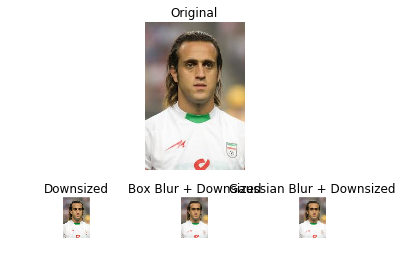

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

I = cv2.imread('karimi.jpg')
s = 4; # downsize with a factor of s

# Downsize by sampling every s pixels:
J = I[::s, ::s, :]


Jb = Jg = J

# blur with a box filter, then downsample
ksize = s + 1;
Ib = cv2.boxFilter(I, -1, (ksize,ksize))
Jb = Ib[::s, ::s, :]


# blur with a Gaussian filter, then resample
sigma = (s+1)/np.sqrt(12) # equivant sigma for Guassian kernel
Ig = cv2.GaussianBlur(I, (0,0),sigma)
Jg = Ig[::s, ::s, :]

f, ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [s,1]})

# do not change this (turns off the axes)
for a in ax.ravel():
    a.axis('off')

ax[0,1].set_title('Original')
ax[0,1].imshow(I[:,:,::-1])

ax[1,0].set_title('Downsized')
ax[1,0].imshow(J[:,:,::-1], interpolation='none')

ax[1,1].set_title('Box Blur + Downsized')
ax[1,1].imshow(Jb[:,:,::-1], interpolation='none');

ax[1,2].set_title('Gaussian Blur + Downsized')
ax[1,2].imshow(Jg[:,:,::-1], interpolation='none');

plt.show()


## Image Pyramid

In [1]:
import numpy as np
import cv2

I = cv2.imread('karimi.jpg')
m,n,_ = I.shape

P1 = np.array([[0,0], [0, m-1], [n-1,0], [n-1,m-1]])

psize = 7 # size of the pyramid (no. of levels)

# building the pyramid

J = np.ones((600,500,3), dtype=np.uint8)*255
m2,n2,_ = J.shape

v  = np.array([(n2/2,0)])
P2 = np.array([(0,4*m2/5),
               (5*n2/6,m2),
               (3*n2/12,7*m2/12),
               (n2,8*m2/12)])

cv2.line(I, (0,0), (0,m-1), (1,1,1),4)
cv2.line(I, (0,0), (n-1,0), (1,1,1),4)
cv2.line(I, (n-1,m-1), (0,m-1), (1,1,1),4)
cv2.line(I, (n-1,m-1), (n-1,0), (1,1,1),4)

for i in range(4):
    cv2.line(J, (v[0,0],v[0,1]), (P2[i,0],P2[i,1]), (0,0,0),2)

p21 = P2[1].copy()
    
for i in range(psize):
    H, status = cv2.findHomography(P1, P2)

    K = cv2.warpPerspective(I, H, (J.shape[1],J.shape[0]))

    msk = K.max(axis=2) != 0

    J[msk,:] = K[msk,:]

    cv2.line(J, (v[0,0],v[0,1]), (p21[0],p21[1]), (0,0,0),2)

    cv2.imshow('',J)
    cv2.waitKey()
    
    P2 = (P2 + v)/2

cv2.destroyAllWindows()

## Multi Scale Corner Detection

In [2]:
import cv2
import numpy as np
   
I = cv2.imread('kntu4.jpg')
G = cv2.cvtColor(I,cv2.COLOR_BGR2GRAY)
G = np.float32(G)

for k in range(1,7):
    win_size = 2**k # 2^k
    soble_kernel_size  = 3 # kernel size for gradients
    alpha = 0.04
    H = cv2.cornerHarris(G,win_size,soble_kernel_size,alpha)
    H = H / H.max()
    
    C = np.uint8(H > 0.01) * 255
    nc,CC = cv2.connectedComponents(C);

    J = I.copy()
    J[C != 0] = [0,0,255]
    cv2.putText(J,'winsize=%d, corners=%d'%(win_size, nc-1),(20,40), \
                cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)
    
    cv2.imshow('corners',J)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

    
cv2.destroyAllWindows() 

● What is the first win_size for which the algorithm detects the right number of
corners?

Answer:

1:=>16


● Test the above code on kntu2.jpg and kntu4.jpg. In each case take note of the
smallest win_size for which the algorithm correctly detects the corners. What
do these numbers say?

Answer:

 1:=>16
 
 2:=>8
 
 4:=>4
 
 So when the image scales down by factor of 2 the window size also must shrink by factor of two
 


## TASK 1

In [3]:
import cv2
import numpy as np

NO_CORNERS = 78

def first_correct_winsize(I):
    "find the smallest win_size for which all corners are detected"
    # write your code here
    I = cv2.cvtColor(I,cv2.COLOR_BGR2GRAY)
    I = np.float32(I)
    soble_kernel_size = 3
    alpha = 0.04
    for k in range(1,8):
        win_size = 2**k
        H = cv2.cornerHarris(I,win_size,soble_kernel_size,alpha)
        H = H / H.max()
        C = np.uint8(H > 0.01) * 255
        nc, CC = cv2.connectedComponents(C);
        if(nc - 1 == 78):
            return 2**k
    
    return None # incorrect


I1 = cv2.imread('kntu1.jpg')
I2 = cv2.imread('kntu4.jpg')

s1 = first_correct_winsize(I1)
s2 = first_correct_winsize(I2)
    
J = np.concatenate((I1,I2), 1)

if s1 < s2:
    txt = 'Logo 1 is %d times smaller than logo 2'%(s2/s1)
elif s1 > s2:
    txt = 'Logo 1 is %d times larger than logo 2'%(s1/s2)
else:
    txt = 'Logo 1 is about the same size as logo 2'
    
cv2.putText(J,txt,(20,40), \
                cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)

cv2.imshow('scale',J)
cv2.waitKey(0)
    
cv2.destroyAllWindows() 

## Multiscale corner detection with image pyramid

In [4]:
import cv2
import numpy as np

I = cv2.imread('kntu1.jpg')

psize = 6 # size of the pyramid (no. of levels)

# building the pyramid
J = I.copy()
Pyr = [J] # the first element is simply the original image
for i in range(psize-1):
    J = cv2.pyrDown(J) # blurs, then downsamples by a factor of 2
    Pyr.append(J)


for k in range(psize): # k = 0,1,..., psize-1
    J = Pyr[k]
    G = cv2.cvtColor(J,cv2.COLOR_BGR2GRAY)
    G = np.float32(G)
    
    win_size = 4 # do not change this
    soble_kernel_size  = 3 # kernel size for gradients
    alpha = 0.04
    H = cv2.cornerHarris(G,win_size,soble_kernel_size,alpha)
    H = H / H.max()
    
    C = np.uint8(H > 0.01) * 255
    nc,CC = cv2.connectedComponents(C);
    
    J[C != 0] = [0,0,255]
    
    JJ = np.zeros(I.shape,dtype=I.dtype)
    JJ[:J.shape[0],:J.shape[1],:] = J;
    cv2.putText(JJ,'scale=1/%d, corners=%d'%(2**k, nc-1),(360,30), \
                cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)
    
    cv2.imshow('corners',JJ)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
    
cv2.destroyAllWindows() 

## TASK 2

In [4]:
import cv2
import numpy as np

NO_CORNERS = 78

def first_correct_scale(I):
    "find the smallest scale for which all corners are detected"

    psize = 6 # size of the pyramid
    
    # building the pyramid
    J = I.copy()
    Pyr = [J] # the first element is simply the original image
    for i in range(psize-1):
        J = cv2.pyrDown(J) # blurs, then downsamples by a factor of 2
        Pyr.append(J)

    for k in range(psize): # k = 0,1,..., psize-1
        J = Pyr[k]
        G = cv2.cvtColor(J,cv2.COLOR_BGR2GRAY)
        G = np.float32(G)
        
    
        win_size = 4 # do not change this!!
        soble_kernel_size  = 3 # kernel size for gradients
        alpha = 0.04

        #! write your code here! *****************************************
        H = cv2.cornerHarris(G,win_size,soble_kernel_size,alpha)
        H = H / H.max()

        C = np.uint8(H > 0.01) * 255
        nc, CC = cv2.connectedComponents(C);
        if (nc - 1 == 78):
            return 2**k

        
        if nc-1 == NO_CORNERS: # if the connected components 
            return 2**k
        

I1 = cv2.imread('kntu1.jpg')
I2 = cv2.imread('kntu4.jpg')

sc1 = first_correct_scale(I1)
sc2 = first_correct_scale(I2)

J = np.concatenate((I1,I2), 1)

if sc1 < sc2:
    txt = 'Logo 1 is %d times smaller than logo 2'%(sc2/sc1)
elif sc1 > sc2:
    txt = 'Logo 1 is %d times larger than logo 2'%(sc1/sc2)
else:
    txt = 'Logo 1 is about the same size as logo 2'
    
cv2.putText(J,txt,(20,40), \
                cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)

cv2.imshow('scale',J)
cv2.waitKey(0)
cv2.destroyAllWindows() 

## FUN

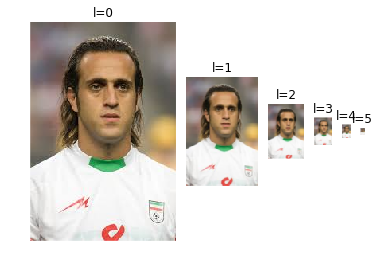

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

I = cv2.imread('karimi.jpg')

psize = 6 # size of the pyramid (no. of levels)

# building the pyramid
J = I.copy()
Pyr = [J] # the first element is simply the original image
for i in range(psize-1):
    J = cv2.pyrDown(J) # blurs, then downsamples by a factor of 2
    Pyr.append(J)

# display the pyramid
# do not bother about the next two lines
size_list = [2**(psize-i-1) for i in range(psize)] 
f, ax = plt.subplots(1,psize, gridspec_kw={'width_ratios': size_list})

# do not change this (turns off the axes)
for a in ax.ravel():
    a.axis('off')

for l in range(psize):
    ax[l].set_title('l=%d'%l)
    J = Pyr[l]
    ax[l].imshow(J[:,:,::-1], interpolation='none');

plt.show()